In [5]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# -------------------------------------------------------------------
# Load core data once
# -------------------------------------------------------------------
PROC_DIR = Path("data/processed")

# Per-account feature table (what we used for modelling)
features = pd.read_parquet(PROC_DIR / "features_labeled.parquet")

# Per-campaign model metrics (followers only vs logistic vs XGBoost)
metrics = pd.read_parquet(PROC_DIR / "model_metrics_per_campaign.parquet")

print("Campaigns in data:", sorted(features["product_name"].unique()))

# -------------------------------------------------------------------
# Per-campaign interaction summary
# -------------------------------------------------------------------
campaign_summary = (
    features
    .groupby("product_name")
    .agg(
        active_accounts=("user_id", "nunique"),
        total_comments=("comment", "sum"),
        total_reposts=("reposts", "sum"),
    )
    .reset_index()
)

campaign_summary["total_interactions"] = (
    campaign_summary["total_comments"] + campaign_summary["total_reposts"]
)

campaign_summary["repost_share"] = np.where(
    campaign_summary["total_interactions"] > 0,
    campaign_summary["total_reposts"] / campaign_summary["total_interactions"],
    0.0,
)

# Sort campaigns by size once so all charts use the same order
campaign_order = (
    campaign_summary
    .sort_values("active_accounts", ascending=True)["product_name"]
    .tolist()
)

campaign_summary = (
    campaign_summary
    .set_index("product_name")
    .loc[campaign_order]
    .reset_index()
)

campaign_summary

Campaigns in data: ['abc_reading', 'electric_toothbrush', 'intelligent_floor_scrubber', 'ruby_face_cream', 'spark_thinking', 'supor_boosted_showerhead']


,product_name,active_accounts,total_comments,total_reposts,total_interactions,repost_share
0,electric_toothbrush,1561,81137,74704,155841,0.479360
1,ruby_face_cream,3059,65814,48635,114449,0.424949
2,supor_boosted_showerhead,5503,110941,67170,178111,0.377124
3,intelligent_floor_scrubber,5959,251301,98171,349472,0.280912
4,abc_reading,6869,310740,112416,423156,0.265661
5,spark_thinking,7138,351688,98730,450418,0.219196


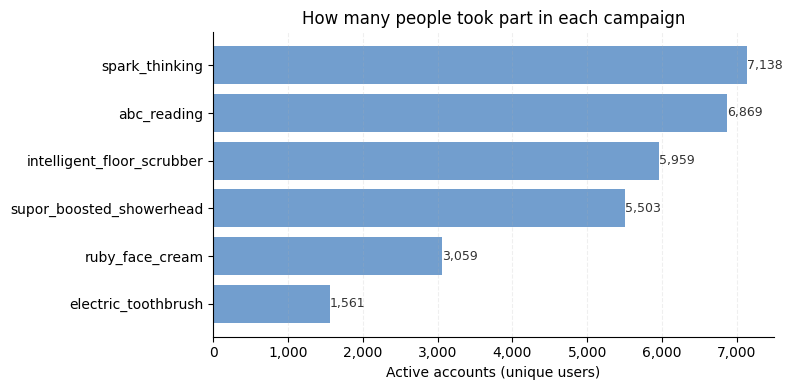

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.barh(
    campaign_summary["product_name"],
    campaign_summary["active_accounts"],
    color="#729ECE",
)

ax.set_xlabel("Active accounts (unique users)")
ax.set_ylabel("")
ax.set_title("How many people took part in each campaign")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

# Light x-grid only, remove extra borders
ax.grid(axis="x", linestyle="--", alpha=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Direct labels at end of bars
for bar, value in zip(bars, campaign_summary["active_accounts"]):
    ax.text(
        value,
        bar.get_y() + bar.get_height() / 2,
        f"{value:,}",
        va="center",
        ha="left",
        fontsize=9,
        color="#333333",
    )

plt.tight_layout()
plt.show()

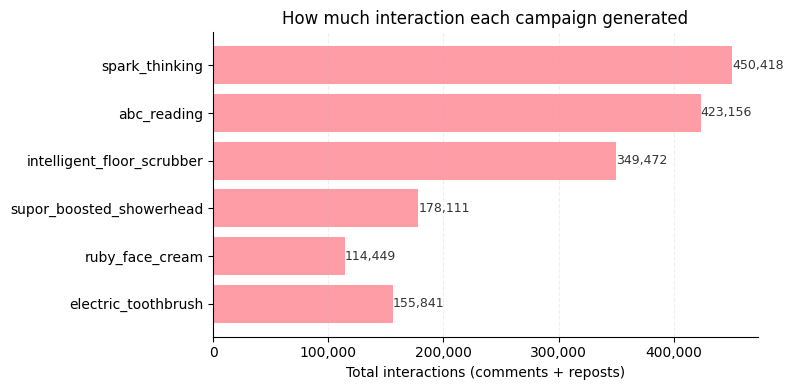

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.barh(
    campaign_summary["product_name"],
    campaign_summary["total_interactions"],
    color="#FF9DA7",
)

ax.set_xlabel("Total interactions (comments + reposts)")
ax.set_ylabel("")
ax.set_title("How much interaction each campaign generated")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

ax.grid(axis="x", linestyle="--", alpha=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for bar, value in zip(bars, campaign_summary["total_interactions"]):
    ax.text(
        value,
        bar.get_y() + bar.get_height() / 2,
        f"{value:,}",
        va="center",
        ha="left",
        fontsize=9,
        color="#333333",
    )

plt.tight_layout()
plt.show()

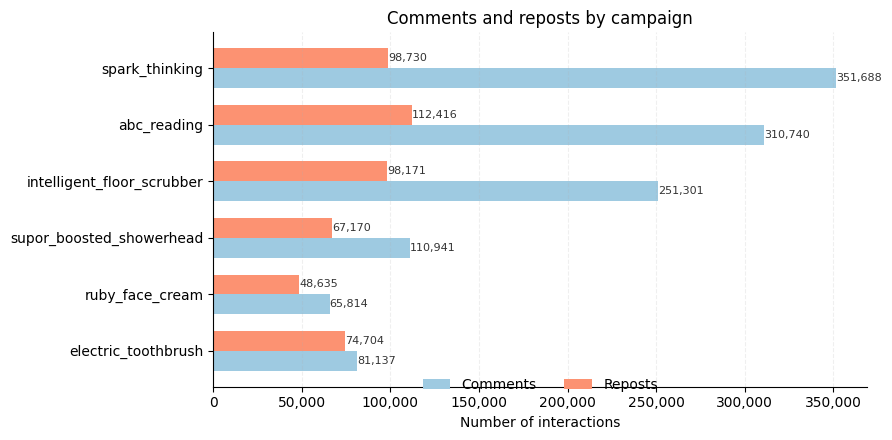

In [8]:
fig, ax = plt.subplots(figsize=(9, 4.5))

y = np.arange(len(campaign_summary))
bar_height = 0.35

comments = campaign_summary["total_comments"].values
reposts = campaign_summary["total_reposts"].values

bars_comments = ax.barh(
    y - bar_height / 2,
    comments,
    height=bar_height,
    label="Comments",
    color="#9ECAE1",
)

bars_reposts = ax.barh(
    y + bar_height / 2,
    reposts,
    height=bar_height,
    label="Reposts",
    color="#FC9272",
)

ax.set_yticks(y)
ax.set_yticklabels(campaign_summary["product_name"])
ax.set_xlabel("Number of interactions")
ax.set_ylabel("")
ax.set_title("Comments and reposts by campaign")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

ax.grid(axis="x", linestyle="--", alpha=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Simple numeric labels at end of each bar
for bar, val in zip(bars_comments, comments):
    ax.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=8,
        color="#333333",
    )

for bar, val in zip(bars_reposts, reposts):
    ax.text(
        val,
        bar.get_y() + bar.get_height() / 2,
        f"{val:,}",
        va="center",
        ha="left",
        fontsize=8,
        color="#333333",
    )

ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

In [9]:
# Keep only the three methods we care about
keep_models = ["logistic_baseline", "logistic_full", "xgboost_full"]
metrics_sub = metrics[metrics["model"].isin(keep_models)].copy()

name_map = {
    "logistic_baseline": "Followers only",
    "logistic_full": "Followers + network (Logistic)",
    "xgboost_full": "Followers + network (XGBoost)",
}

metrics_sub["method"] = metrics_sub["model"].map(name_map)

# Make sure campaigns are in the same order as the summary
metrics_sub["product_name"] = pd.Categorical(
    metrics_sub["product_name"],
    categories=campaign_order,
    ordered=True,
)

metrics_sub = metrics_sub.sort_values(["product_name", "method"])

metrics_sub.head()

,product_name,model,f1,roc_auc,p@50,p@100,method
4,electric_toothbrush,logistic_full,0.890052,0.987005,1.0,0.87,Followers + network (Logistic)
5,electric_toothbrush,xgboost_full,0.911917,0.982774,1.0,0.91,Followers + network (XGBoost)
3,electric_toothbrush,logistic_baseline,0.000000,0.612244,0.4,0.30,Followers only
10,ruby_face_cream,logistic_full,0.723647,0.839575,1.0,0.99,Followers + network (Logistic)
11,ruby_face_cream,xgboost_full,0.712329,0.848957,1.0,0.99,Followers + network (XGBoost)


In [12]:
from matplotlib.ticker import FuncFormatter

def plot_precision_at_k(metrics_df, k=50):
    """
    Plot, for each campaign, the share of top-K picks that were truly high-engagement
    for each method, with legend on the right.
    """
    col = f"p@{k}"
    if col not in metrics_df.columns:
        raise ValueError(f"Column {col!r} not found in metrics dataframe")

    methods = [
        "Followers only",
        "Followers + network (Logistic)",
        "Followers + network (XGBoost)",
    ]

    # Pivot to wide format: rows = campaigns, cols = methods
    wide = (
        metrics_df
        .pivot(index="product_name", columns="method", values=col)
        .reindex(campaign_order)
    )

    # Extra width to make room for the legend on the right
    fig_height = 2.5 + 0.4 * len(wide)
    fig, ax = plt.subplots(figsize=(10, fig_height))

    y = np.arange(len(wide))
    bar_height = 0.22

    colors = {
        "Followers only": "#9ECAE1",
        "Followers + network (Logistic)": "#A1D99B",
        "Followers + network (XGBoost)": "#FC9272",
    }

    for i, method in enumerate(methods):
        if method not in wide.columns:
            continue

        offsets = y + (i - 1) * bar_height
        values = wide[method].fillna(0).values

        bars = ax.barh(
            offsets,
            values,
            height=bar_height,
            label=method,
            color=colors.get(method, None),
        )

        for bar, v in zip(bars, values):
            ax.text(
                v,
                bar.get_y() + bar.get_height() / 2,
                f"{v*100:.0f}%",
                va="center",
                ha="left",
                fontsize=8,
                color="#333333",
            )

    ax.set_yticks(y)
    ax.set_yticklabels(wide.index)
    ax.set_xlabel(f"Share of top-{k} picks that were truly high-engagement")
    ax.set_ylabel("")
    ax.set_title(f"How good is each method at picking the top {k} accounts?")

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x*100:.0f}%"))
    ax.set_xlim(0, 1.05)

    ax.grid(axis="x", linestyle="--", alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Legend on the right, vertical
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
        borderaxespad=0.0,
    )

    # Leave space on the right for the legend
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()

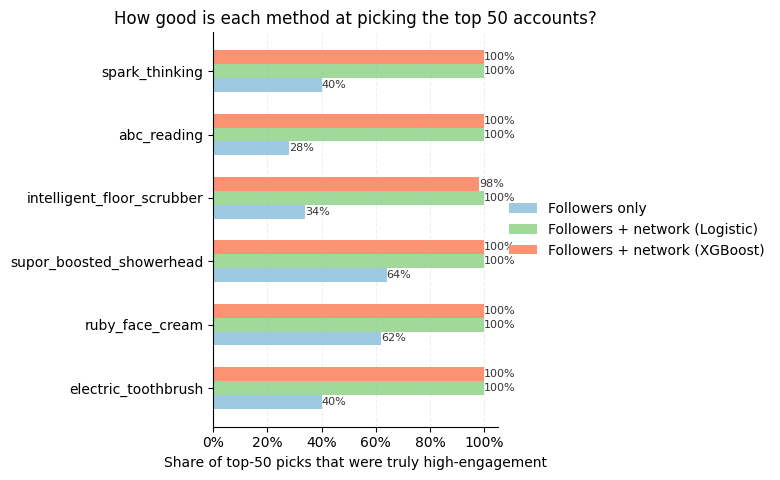

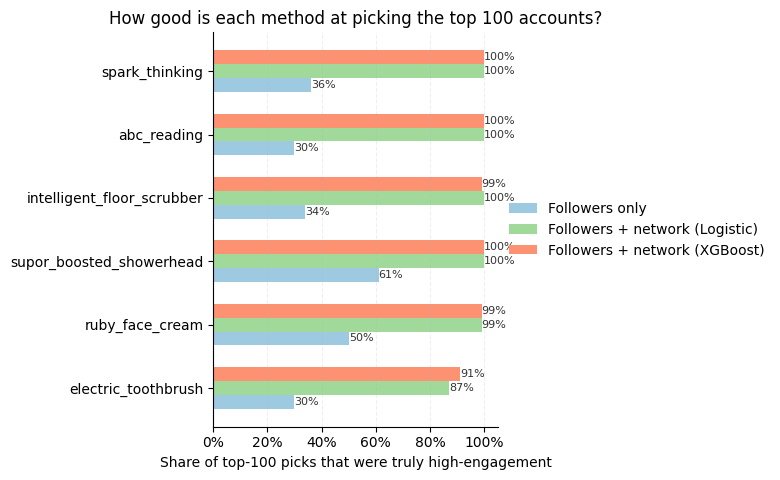

In [13]:
plot_precision_at_k(metrics_sub, k=50)
plot_precision_at_k(metrics_sub, k=100)